In [23]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks. Thanks to viewer Daniel BA1/4hler for this suggestion

TRAIN_DIR = '../Datasets/dc/train'
TEST_DIR = '../Datasets/dc/test'
IMG_SIZE = 50
LR = 1e-3

MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '2conv-basic')

In [9]:
def label_img(img):
    word_label = img.split('.')[-3]
    # conversion to one-hot array [cat,dog]
    #                            [much cat, no dog]
    if word_label == 'cat': return [1,0]
    #                             [no cat, very doggo]
    elif word_label == 'dog': return [0,1]

In [10]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data




In [11]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [12]:
#train_data = create_train_data()
train_data = np.load('train_data.npy')


100%|██████████| 25000/25000 [01:43<00:00, 242.29it/s]


In [13]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')


curses is not supported on this machine (please install/reinstall curses for an optimal experience)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.


In [14]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

In [15]:
train = train_data[:-500]
test = train_data[-500:]

In [16]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

In [17]:
model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 1148  | total loss: 0.69320 | time: 45.909s
| Adam | epoch: 003 | loss: 0.69320 - acc: 0.5002 -- iter: 24448/24500
Training Step: 1149  | total loss: 0.69319 | time: 47.051s
| Adam | epoch: 003 | loss: 0.69319 - acc: 0.5017 | val_loss: 0.69316 - val_acc: 0.4980 -- iter: 24500/24500
--


In [18]:
model.save(MODEL_NAME)


INFO:tensorflow:C:\Users\skzt\PycharmProjects\tcc\test\Own Dataset\dogsvscats-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


In [24]:
process_test_data()

100%|██████████| 1/1 [00:00<00:00, 77.63it/s]


[[array([[ 41,  43,  33, ..., 164, 163, 159],
         [ 40,  47,  35, ..., 157, 158, 171],
         [ 32,  25,  28, ..., 160, 160, 163],
         ...,
         [ 35,  61,  83, ..., 199, 202, 206],
         [ 29,  39,  67, ..., 199, 199, 203],
         [ 13,  36,  52, ..., 198, 198, 200]], dtype=uint8), '01']]

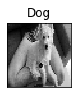

In [25]:
import matplotlib.pyplot as plt

# if you need to create the data:
#test_data = process_test_data()
# if you already have some saved:
test_data = np.load('test_data.npy')

fig=plt.figure()

for num,data in enumerate(test_data[:12]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()